# Ejemplo de CRISP-DM

## Simluación de datos

In [1]:
# %% ------------------ Imports y RNG ------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

rng = np.random.default_rng(42)

# %% ------------------ Simulador cohorte rehab ictus ------------------
def simulate_stroke_rehab_regression(n=300):
    age = rng.normal(62, 12, n).clip(18, 90)
    sex = rng.choice(["F","M"], size=n, p=[0.52, 0.48])
    nihss = rng.integers(0, 16, n)                             # muestra ambulatoria
    days_since_stroke = rng.integers(14, 180, n)               # 2 semanas a 6 meses
    comorb = rng.poisson(1.2, n).clip(0, 6)

    sixmwt_base = rng.normal(250, 95, n).clip(30, 600)         # m
    tug_base = rng.normal(25, 10, n).clip(8, 120)              # s

    therapy_min = rng.normal(160, 40, n).clip(40, 360)         # min/semana
    cadence = rng.normal(90, 15, n).clip(40, 140)              # pasos/min
    step_var = np.abs(rng.normal(0.12, 0.05, n))               # CV (adimensional)

    # Mecanismo generador para Δ6MWT (señal + ruido)
    signal = (
        0.30*(therapy_min-160) +
        1.2*(cadence-90) -
        120*(step_var-0.12) -
        4.0*nihss -
        0.08*(days_since_stroke-60) -
        2.0*(tug_base-25) -
        8.0*comorb +
        0.12*(sixmwt_base-250)
    )
    noise = rng.normal(0, 40, n)
    delta_6mwt = (120 + signal + noise).clip(-50, 300)         # m, plausibilidad

    df = pd.DataFrame({
        "age": age.round(1),
        "sex": sex,
        "nihss": nihss.astype(int),
        "days_since_stroke": days_since_stroke.astype(int),
        "comorb": comorb.astype(int),
        "sixmwt_base": sixmwt_base.round(1),
        "tug_base": tug_base.round(1),
        "therapy_min": therapy_min.round(1),
        "cadence": cadence.round(1),
        "step_var": step_var.round(3),
        "delta_6mwt": delta_6mwt.round(1)
    })

    # Problemas de calidad intencionales para practicar:
    # 1) Faltantes en ~5% de columnas clave
    for col in ["sixmwt_base", "tug_base", "therapy_min"]:
        idx = rng.choice(df.index, size=int(0.05*n), replace=False)
        df.loc[idx, col] = np.nan

    # 2) Outliers puntuales en dosis de terapia
    idx_hi = rng.choice(df.index, size=max(1, n//100), replace=False)
    df.loc[idx_hi, "therapy_min"] = df["therapy_min"].max() * 3

    return df

df = simulate_stroke_rehab_regression(n=1000)
print(df.head())
print("\nShape:", df.shape)


    age sex  nihss  days_since_stroke  comorb  sixmwt_base  tug_base  \
0  65.7   M      1                164       2        264.1      21.0   
1  49.5   F     12                111       0        354.0      13.0   
2  71.0   F     13                 42       1        180.6      44.9   
3  73.3   F     15                143       3        253.0      24.0   
4  38.6   F      5                 37       2          NaN      31.4   

   therapy_min  cadence  step_var  delta_6mwt  
0        230.4    103.2     0.104       132.7  
1        180.9     93.2     0.073        72.9  
2        238.6     98.3     0.143        43.7  
3        196.0     85.3     0.143        74.2  
4         87.8     91.7     0.097        56.7  

Shape: (1000, 11)


## Data Understanding


=== Cardinalidad & Faltantes ===
                     dtype n_unique pct_unique n_missing pct_missing
age                float64      411       41.1         0         0.0
sex                 object        2        0.2         0         0.0
nihss                int64       16        1.6         0         0.0
days_since_stroke    int64      166       16.6         0         0.0
comorb               int64        7        0.7         0         0.0
sixmwt_base        float64      821       82.1        50         5.0
tug_base           float64      336       33.6        50         5.0
therapy_min        float64      677       67.7        50         5.0
cadence            float64      495       49.5         0         0.0
step_var           float64      222       22.2         0         0.0
delta_6mwt         float64      771       77.1         0         0.0

=== Resumen numérico ===
                    count unique  top freq        mean        std   min  \
age                1000.0    NaN  NaN

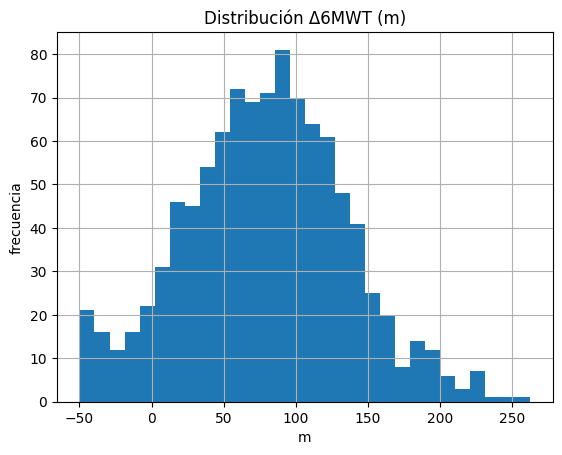

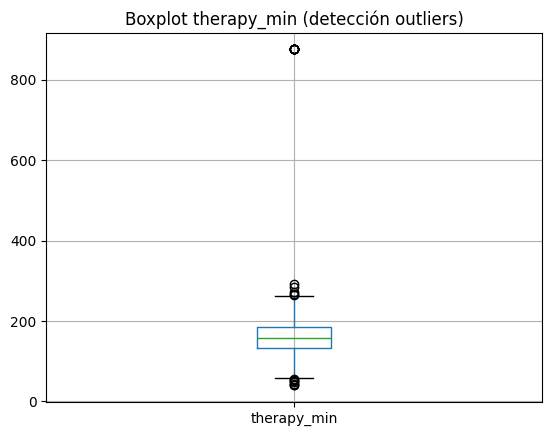

In [2]:
# %% ------------------ Perfil exploratorio básico ------------------
def describe_cardinality(s: pd.Series):
    return pd.Series({
        "dtype": s.dtype,
        "n_unique": s.nunique(dropna=True),
        "pct_unique": 100*s.nunique(dropna=True)/len(s),
        "n_missing": s.isna().sum(),
        "pct_missing": 100*s.isna().mean()
    })

profile = df.apply(describe_cardinality).T
summary = df.describe(include="all").T

print("\n=== Cardinalidad & Faltantes ===")
print(profile)

print("\n=== Resumen numérico ===")
print(summary)

# %% ------------------ Detección simple de outliers (IQR) ------------------
def iqr_outliers_report(df_numeric: pd.DataFrame, k=1.5):
    rows = []
    for col in df_numeric.columns:
        x = df_numeric[col].dropna().values
        q1, q3 = np.percentile(x, [25, 75])
        iqr = q3 - q1
        lo, hi = q1 - k*iqr, q3 + k*iqr
        n_lo = (df_numeric[col] < lo).sum()
        n_hi = (df_numeric[col] > hi).sum()
        rows.append({"variable": col, "q1": q1, "q3": q3, "iqr": iqr,
                     "low_thresh": lo, "high_thresh": hi,
                     "n_low": int(n_lo), "n_high": int(n_hi)})
    return pd.DataFrame(rows).sort_values("n_high", ascending=False)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
outliers_table = iqr_outliers_report(df[num_cols])
print("\n=== Outliers (IQR 1.5) ===")
print(outliers_table)

# %% ------------------ Visual quick checks (opcional) ------------------
plt.figure()
df["delta_6mwt"].hist(bins=30)
plt.title("Distribución Δ6MWT (m)")
plt.xlabel("m"); plt.ylabel("frecuencia")
plt.show()

plt.figure()
df.boxplot(column=["therapy_min"])
plt.title("Boxplot therapy_min (detección outliers)")
plt.show()


## Data Quality

In [3]:
# %% ------------------ Plan de calidad de datos ------------------
# 1) Imputación: media para numéricos; mantén categóricas como 'missing' si aplica.
numeric_features = ["age","nihss","days_since_stroke","comorb",
                    "sixmwt_base","tug_base","therapy_min","cadence","step_var"]
categorical_features = ["sex"]

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

# 2) Escalado (para modelos lineales/regularizados)
num_scaler = StandardScaler()

# 3) Codificación one-hot de categóricas
ohe = OneHotEncoder(drop="if_binary", handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", num_imputer), ("scaler", num_scaler)]), numeric_features),
        ("cat", Pipeline([("imputer", cat_imputer), ("ohe", ohe)]), categorical_features),
    ]
)


## Baseline de Modelado

In [4]:
# %% ------------------ Partición y métricas ------------------
X = df.drop(columns=["delta_6mwt"])
y = df["delta_6mwt"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7
)

scorers = {
    "MAE": make_scorer(mean_absolute_error),
    "RMSE": make_scorer(lambda yt, yp: mean_squared_error(yt, yp)),
    "R2": make_scorer(r2_score),
}

cv = KFold(n_splits=5, shuffle=True, random_state=7)

def evaluate_model(model, name):
    pipe = Pipeline(steps=[("prep", preprocess), ("model", model)])
    cvres = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scorers, n_jobs=-1)
    print(f"\n{name} - CV resultados (train):")
    for m in scorers.keys():
        print(f"  {m}: {cvres['test_'+m].mean():.2f} ± {cvres['test_'+m].std():.2f}")
    pipe.fit(X_train, y_train)
    yhat = pipe.predict(X_test)
    print(f"{name} - Test:")
    print(f"  MAE:  {mean_absolute_error(y_test, yhat):.2f}")
    print(f"  RMSE: {mean_squared_error(y_test, yhat):.2f}")
    print(f"  R2:   {r2_score(y_test, yhat):.3f}")
    return pipe

lin = evaluate_model(LinearRegression(), "LinearRegression")
rid = evaluate_model(Ridge(alpha=1.0), "Ridge(alpha=1.0)")
las = evaluate_model(Lasso(alpha=0.05, max_iter=5000), "Lasso(alpha=0.05)")



LinearRegression - CV resultados (train):
  MAE: 34.25 ± 2.12
  RMSE: 1809.09 ± 156.01
  R2: 0.42 ± 0.06
LinearRegression - Test:
  MAE:  32.75
  RMSE: 1691.19
  R2:   0.464

Ridge(alpha=1.0) - CV resultados (train):
  MAE: 34.25 ± 2.12
  RMSE: 1808.99 ± 155.65
  R2: 0.42 ± 0.06
Ridge(alpha=1.0) - Test:
  MAE:  32.75
  RMSE: 1690.92
  R2:   0.464

Lasso(alpha=0.05) - CV resultados (train):
  MAE: 34.24 ± 2.12
  RMSE: 1809.04 ± 155.68
  R2: 0.42 ± 0.06
Lasso(alpha=0.05) - Test:
  MAE:  32.73
  RMSE: 1689.67
  R2:   0.465
